# Feature Engineering

This notebook creates the training dataset by merging three real datasets:
1. **Historical Crop Performance**: Actual yields per crop-province-year
2. **Soil Test Data**: Real farmer soil conditions (NPK, pH) aggregated by province
3. **Climate Data**: 5-year averages (2020-2024) for temperature, rainfall, humidity

Then:
- Extracts 9 features for each crop-province-soil combination
- Creates target suitability scores from actual historical yields
- Uses REAL data instead of simulated values


In [2]:
import pandas as pd
import numpy as np
import sys
import random
from pathlib import Path
from sklearn.model_selection import train_test_split

# Add app to path to import modules
project_root = Path("../").resolve()
sys.path.append(str(project_root))

from app.services.data_loader import DataLoader
from app.services.feature_extractor import FeatureExtractor
from app.utils.data_processor import normalize_npk_level, parse_ph_range, parse_soil_types

# Initialize with explicit data directory path
data_dir = project_root / "raw_datasets"
data_loader = DataLoader(data_dir=str(data_dir))
data_loader.load_all_data()
feature_extractor = FeatureExtractor()

print("Data loaded successfully!")


Loading datasets...
Loaded 104 crop climate requirements
Loaded 104 crop requirements
Loaded 104 NPK requirements
Loaded 93369 historical performance records
Loading climate data (this may take a moment)...
Loaded 215556 climate records
Creating unified crop database...
Unified database created with 104 crops
Data loaded successfully!


In [3]:
# Load historical performance and calculate yields
historical_perf = pd.read_csv("../raw_datasets/historical_crop_performance.csv")
historical_perf['yield_per_ha'] = (
    historical_perf['Volume_Production'] / historical_perf['Area_Planted_Harvested']
)

# Clean data
historical_perf_clean = historical_perf[
    (historical_perf['yield_per_ha'].notna()) & 
    (historical_perf['yield_per_ha'] != float('inf')) &
    (historical_perf['yield_per_ha'] > 0)
].copy()

print(f"Valid yield records: {len(historical_perf_clean)}")


Valid yield records: 93369


In [4]:
# Load and aggregate soil test data
print("Loading soil test data...")
soil_test_df = pd.read_csv("../raw_datasets/soil_test_data.csv")
print(f"Loaded {len(soil_test_df)} soil test records")

# Normalize province names for matching
soil_test_df['province_normalized'] = soil_test_df['province'].str.strip().str.title()

# Aggregate soil data by province (get most common values)
def get_mode_or_default(series, default='Medium'):
    """Get mode value or return default if empty."""
    mode_values = series.mode()
    return mode_values[0] if len(mode_values) > 0 else default

province_soil_agg = soil_test_df.groupby('province_normalized').agg({
    'nitrogen': lambda x: get_mode_or_default(x, 'Medium'),
    'phosphorus': lambda x: get_mode_or_default(x, 'Medium'),
    'potassium': lambda x: get_mode_or_default(x, 'Medium'),
    'ph_min': 'mean',
    'ph_max': 'mean'
}).reset_index()
province_soil_agg.columns = ['province', 'nitrogen', 'phosphorus', 'potassium', 'ph_min', 'ph_max']

print(f"Aggregated soil data for {len(province_soil_agg)} provinces")

# Normalize province names in historical data for merging
historical_perf_clean['Province_normalized'] = historical_perf_clean['Province'].str.strip().str.title()

# Merge historical performance with soil data
print("\nMerging historical data with soil data...")
merged_data = historical_perf_clean.merge(
    province_soil_agg,
    left_on='Province_normalized',
    right_on='province',
    how='inner'  # Only keep records with soil data
)

print(f"Total merged records: {len(merged_data)}")
print(f"Records with soil data: {merged_data['nitrogen'].notna().sum()}")
print(f"Unique crop-province combinations with soil data: {merged_data[['Crop', 'Province']].drop_duplicates().shape[0]}")


Loading soil test data...
Loaded 22242 soil test records
Aggregated soil data for 62 provinces

Merging historical data with soil data...
Total merged records: 65898
Records with soil data: 65898
Unique crop-province combinations with soil data: 3935


In [5]:
merged_data.head()

,Crop,Province,Year,Volume_Production,Area_Planted_Harvested,yield_per_ha,Province_normalized,province,nitrogen,phosphorus,potassium,ph_min,ph_max
0,Alugbati (Malabar spinach),Abra,2023,0.75,0.92,0.815217,Abra,Abra,Low,Low,Low,6.026508,7.296770
1,Alugbati (Malabar spinach),Abra,2024,0.51,1.00,0.510000,Abra,Abra,Low,Low,Low,6.026508,7.296770
2,Alugbati (Malabar spinach),Agusan del Norte,2010,48.65,12.00,4.054167,Agusan Del Norte,Agusan Del Norte,High,Low,Medium,5.833333,7.064912
3,Alugbati (Malabar spinach),Agusan del Norte,2011,45.85,10.00,4.585000,Agusan Del Norte,Agusan Del Norte,High,Low,Medium,5.833333,7.064912
4,Alugbati (Malabar spinach),Agusan del Norte,2012,42.00,9.50,4.421053,Agusan Del Norte,Agusan Del Norte,High,Low,Medium,5.833333,7.064912


In [4]:
# Calculate the 95th percentile yield for each crop
max_yield_per_crop = historical_perf_clean.groupby('Crop')['yield_per_ha'].quantile(0.95)

# Create training dataset using the entire merged dataset
training_data = []

print(f"Processing {len(merged_data)} records...")

for idx, row in merged_data.iterrows():
    crop_name = row['Crop']
    province = row['Province']
    yield_per_ha = row['yield_per_ha']
    
    try:
        crop_data = data_loader.get_crop_by_name(crop_name)
        if crop_data is None:
            continue
        
        climate = data_loader.get_climate_averages(province, None)
        if not all([climate['temperature'], climate['rainfall'], climate['humidity']]):
            continue
        
        # Use a realistic soil type
        acceptable_soils = parse_soil_types(crop_data.get('Acceptable_Soil_Types', 'Loam'))
        farmer_soil_type = random.choice(acceptable_soils) if acceptable_soils else 'Loam'

        features = feature_extractor.extract_features(
            crop_data=crop_data,
            farmer_nitrogen=str(row['nitrogen']),
            farmer_phosphorus=str(row['phosphorus']),
            farmer_potassium=str(row['potassium']),
            farmer_ph_min=float(row['ph_min']),
            farmer_ph_max=float(row['ph_max']),
            farmer_soil_type=farmer_soil_type,
            avg_temperature=climate['temperature'],
            avg_rainfall=climate['rainfall'],
            avg_humidity=climate['humidity'],
            historical_yield_data=data_loader.get_historical_yield(crop_name, province),
            current_month=6
        )
        
        # Dynamic suitability score
        max_yield = max_yield_per_crop.get(crop_name, 20) # Default to 20 if crop not in series
        suitability_score = min(100.0, max(0.0, (yield_per_ha / max_yield) * 80.0 + 20.0))
        
        training_row = features.copy()
        training_row['suitability_score'] = suitability_score
        training_row['crop_name'] = crop_name
        training_row['province'] = province
        training_row['category'] = crop_data.get('Category', 'Unknown')
        training_row['actual_yield'] = yield_per_ha
        
        training_data.append(training_row)
        
    except Exception as e:
        continue
    
    if len(training_data) % 5000 == 0:
        print(f"Processed {len(training_data)} records...")

print(f"\nTotal training records created: {len(training_data)}")


Processing 65898 records...
Processed 5000 records...
Processed 10000 records...
Processed 15000 records...
Processed 20000 records...
Processed 25000 records...
Processed 30000 records...
Processed 35000 records...
Processed 40000 records...
Processed 45000 records...
Processed 50000 records...
Processed 55000 records...
Processed 60000 records...

Total training records created: 64290


In [5]:
# Convert to DataFrame
train_df = pd.DataFrame(training_data)
print("Full dataset shape:", train_df.shape)

# Split data into training and validation sets
train_set, val_set = train_test_split(train_df, test_size=0.2, random_state=42)

print(f"Training set shape: {train_set.shape}")
print(f"Validation set shape: {val_set.shape}")

# Save the datasets
output_dir = Path("../models")
train_set.to_csv(output_dir / "training_dataset.csv", index=False)
val_set.to_csv(output_dir / "validation_dataset.csv", index=False)

print("\nTraining and validation datasets saved successfully!")


Full dataset shape: (64290, 14)
Training set shape: (51432, 14)
Validation set shape: (12858, 14)

Training and validation datasets saved successfully!


In [3]:
import pandas as pd

In [4]:
train_df = pd.read_csv("../models/training_dataset.csv")
val_df = pd.read_csv("../models/validation_dataset.csv")

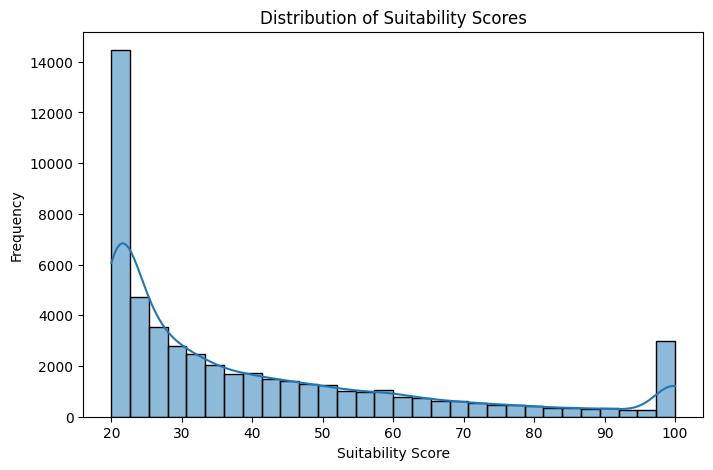

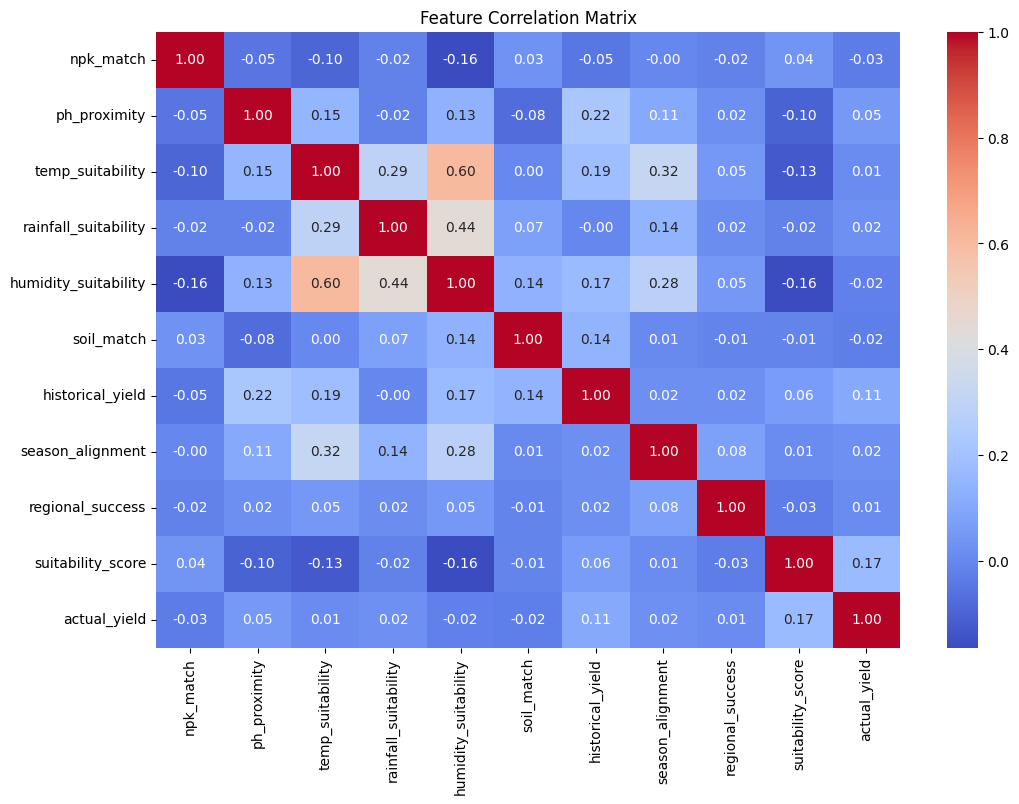

In [5]:
import seaborn as sns

import matplotlib.pyplot as plt

# Visualize distribution of suitability scores
plt.figure(figsize=(8, 5))
sns.histplot(train_df['suitability_score'], bins=30, kde=True)
plt.title('Distribution of Suitability Scores')
plt.xlabel('Suitability Score')
plt.ylabel('Frequency')
plt.show()

# Visualize feature correlations
plt.figure(figsize=(12, 8))
corr = train_df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()